some ideas: https://stackoverflow.com/questions/41488279/neural-network-always-predicts-the-same-class

more ideas: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
<pre>

---------------------- TODO --------------------------------------

1) 
 

---------------------- DONE --------------------------------------
change the split and downsampling order

now: start with an imbalanced dataset
     downsample all the data to a small balanced subset
     split and shape using stratify the small subset into 70/30 for Train/Test
     means the Test dataset is also balanced
     
want: start with imbalanced dataset
      split using sklearn:train_test_split into 70/30 for Train/Test
      downsample and shape the Train dataset to become balanced
      shape the Test dataset
      means the Test dataset is imbalanced as it should be
      
      normalize the 3 datasets before building the model using StandardScaler
      create a validation dataset to give a true unbiased result of my final models performance


In [1]:
import os
colab = os.environ.get('COLAB_GPU', '10')
if (int(colab) == 0):
    from google.colab import drive
    drive.mount('/content/drive')  
else:
    print("")

In [2]:
# Check if Google Colab path exists
if os.path.exists("/content/drive/My Drive/MyDSNotebooks/Imbalanced_data/input/creditcardzip") :
    # Change the current working Directory    
    os.chdir("/content/drive/My Drive/MyDSNotebooks/Imbalanced_data/input/creditcardzip")
# else check if Kaggle/local path exists
elif os.path.exists("../input/creditcardzip") :
    # Change the current working Directory    
    os.chdir("../input/creditcardzip")
else:
    print("Can't change the Current Working Directory") 
print("Current Working Directory " , os.getcwd())

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Embedding
#from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import optimizers
from keras import initializers
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

# -------------------------------------------------------
#initialize variables
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cm_results = []
class_names=[0,1] # name  of classes 1=fraudulent transaction

Current Working Directory  C:\DataScience\Repo\Imbalanced_data\input\creditcardzip


Using TensorFlow backend.


In [3]:
def my_learning_rate(epoch, lrate):
	return lrate 

In [4]:
def display_metrics(model_name, train_features, test_features, train_label, test_label, pred):
    try:
        print(model_name.score(test_features, test_label)) 
        print("Accuracy score (training): {0:.3f}".format(model_name.score(train_features, train_label))) 
        print("Accuracy score (validation): {0:.3f}".format(model_name.score(test_features, test_label))) 
    except Exception as e:
        print("error")  
    try:
        print(pd.Series(model_name.feature_importances_, index=train_features.columns[:]).nlargest(10).plot(kind='barh')) 
    except Exception as e:
        print("error")  
        
    print("Confusion Matrix:")
    tn, fp, fn, tp = confusion_matrix(test_label, pred).ravel()
    total = tn+ fp+ fn+ tp 
    print("false positive pct:",(fp/total)*100) 
    print("tn", " fp", " fn", " tp") 
    print(tn, fp, fn, tp) 
    print(confusion_matrix(test_label, pred)) 
    print("Classification Report") 
    print(classification_report(test_label, pred))
    print("Specificity =", tn/(tn+fp))
    print("Sensitivity =", tp/(tp+fn))
    return tn, fp, fn, tp

In [5]:
def CalcPct(df,title):
    unique_elements, counts_elements = np.unique(df, return_counts=True)
    calc_pct = round(counts_elements[1]/(counts_elements[0]+counts_elements[1]) * 100,6)
    print(title)
    print(np.asarray((unique_elements, counts_elements)))
    return calc_pct

In [6]:
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

In [7]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [8]:
#try some data cleansing

temp_df = df.copy()
temp_df = temp_df.drop(['Time'], axis=1)
temp_df['Log_Amount'] = np.log(temp_df.pop('Amount')+0.001)
df = temp_df.copy()

In [9]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.260067
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,3.210481
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,4.217756
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,2.302685


In [10]:
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']
OrigPct = CalcPct(y,"Original")

#print(y['Class'].value_counts())
# split the dataset
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = None, shuffle=True)
test_size = 0.3
val_size = 0.5

strat = True
if (strat == True):
    stratify=y['Class']
else:
    stratify="None"
# stratify will ensure that Train, Test and Validation get the same pct of minority classes (.17%)
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = None, shuffle=True, stratify=stratify)
X_train, X_test1, y_train, y_test1 = train_test_split(X,y, test_size = test_size, random_state = None, shuffle=True, stratify=stratify)
# then split Test1 into Test and Validate
# Validate will be used as a final benchmark, once all the parameter tuning is completed
X_test, X_val, y_test, y_val = train_test_split(X_test1,y_test1, test_size = val_size, random_state = None, shuffle=True)

TrainPct = CalcPct(y_train,"Train")
TestPct = CalcPct(y_test,"Train")
ValPct = CalcPct(y_val,"Train")
zeros, ones = np.bincount(y_train['Class'])

Original
[[     0      1]
 [284315    492]]
Train
[[     0      1]
 [199020    344]]
Train
[[    0     1]
 [42647    74]]
Train
[[    0     1]
 [42648    74]]


In [11]:
# final data validation

# Form np arrays of labels and features.

train_labels = np.array(y_train).flatten()
bool_train_labels = train_labels != 0 # has an extra ,1 in the bool_train_labels.shape
val_labels = np.array(y_val)
test_labels = np.array(y_test)
train_features = np.array(X_train)
val_features = np.array(X_val)
test_features = np.array(X_test)

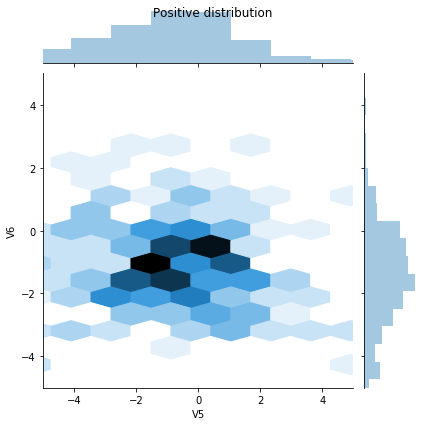

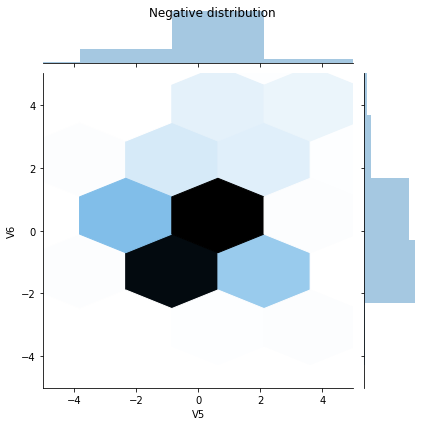

In [12]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = X.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = X.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

In [13]:
# prepare the Train, Test and Validation data for the model. Need input to include arrays with certain shape

# downsample the Train data

# find the number of minority (value=1) samples in our dataset so we can down-sample our majority to it
yes = len(y_train[y_train['Class'] ==1])

# retrieve the indices of the minority and majority samples 
yes_ind = y_train[y_train['Class'] == 1].index
no_ind = y_train[y_train['Class'] == 0].index

# random sample the majority indices based on the amount of 
# minority samples
new_no_ind = np.random.choice(no_ind, yes, replace = False)

# merge the two indices together
undersample_ind = np.concatenate([new_no_ind, yes_ind])

# get undersampled dataframe from the merged indices of the dataset
X_train = X_train.loc[undersample_ind]
y_temp = y_train.loc[undersample_ind]
y_train_original = np.array(y_temp['Class'], dtype='int')
TrainDownPct = CalcPct(y_train_original,"TrainDownSampled")
y_test_original = np.array(y_test['Class'], dtype='int')
TestPct = CalcPct(y_test_original,"Test")
y_val_original = np.array(y_val['Class'], dtype='int')
ValPct = CalcPct(y_val_original,"Val")

# normalize the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

# handle any extreme fliers, set to 5 or -5
X_train = np.clip(X_train, -5, 5)
X_test = np.clip(X_test, -5, 5)
X_val = np.clip(X_val, -5, 5)

#shape the Train data 
rolling_window_size = 10  ### this selects how many historical transactions should be analyzed to judge the transaction at hand -- RNN width

X_train_interim = np.zeros([(X_train.shape[0]-rolling_window_size)*rolling_window_size,X_train.shape[1]]) # change 30 to a variable
y_train = []
for i in range((X_train.shape[0]-rolling_window_size)):
    beg = 0+i
    end = beg+rolling_window_size
    s = np.array(X_train[beg:end], dtype='float')
    X_train_interim[(rolling_window_size*i):(rolling_window_size*(i+1)),:] = s
    y_train.append(y_train_original[end])

y_train = np.array(y_train, dtype='int')
X_train_interim = X_train_interim[:,1::]

X_train_tensor = X_train_interim.reshape(int(np.shape(X_train_interim)[0]/rolling_window_size), rolling_window_size, np.shape(X_train_interim)[1])
X_train = X_train_tensor

#shape the Test data for LSTM !!!

X_test_interim = np.zeros([(X_test.shape[0]-rolling_window_size)*rolling_window_size,X_test.shape[1]])
y_test = []
for i in range((X_test.shape[0]-rolling_window_size)):
    beg = 0+i
    end = beg+rolling_window_size
    s = np.array(X_test[beg:end], dtype='float')
    X_test_interim[(rolling_window_size*i):(rolling_window_size*(i+1)),:] = s
    y_test.append(y_test_original[end]) 

y_test = np.array(y_test, dtype='int')
X_test_interim = X_test_interim[:,1::]

X_test_tensor = X_test_interim.reshape(int(np.shape(X_test_interim)[0]/rolling_window_size), rolling_window_size, np.shape(X_test_interim)[1])
X_test = X_test_tensor

#shape the Val data for LSTM

X_val_interim = np.zeros([(X_val.shape[0]-rolling_window_size)*rolling_window_size,X_val.shape[1]])
y_val = []
for i in range((X_val.shape[0]-rolling_window_size)):
    beg = 0+i
    end = beg+rolling_window_size
    s = np.array(X_val[beg:end], dtype='float')
    X_val_interim[(rolling_window_size*i):(rolling_window_size*(i+1)),:] = s
    y_val.append(y_val_original[end]) 

y_val = np.array(y_val, dtype='int')
X_val_interim = X_val_interim[:,1::]

X_val_tensor = X_val_interim.reshape(int(np.shape(X_val_interim)[0]/rolling_window_size), rolling_window_size, np.shape(X_val_interim)[1])
X_val = X_val_tensor

TrainDownSampled
[[  0   1]
 [344 344]]
Test
[[    0     1]
 [42647    74]]
Val
[[    0     1]
 [42648    74]]


In [14]:
# final data validation

# Form np arrays of labels and features.

train_labels = np.array(y_train)
bool_train_labels = train_labels != 0
val_labels = np.array(y_val)
test_labels = np.array(y_test)

train_features = np.array(X_train)
val_features = np.array(X_val)
test_features = np.array(X_test)

In [15]:
# run model
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
### Hyperparameters Tuning
# First test optimal epochs holding everything else constant
# Dropout: 0.1-0.6
# GradientClipping: 0.1-10
# BatchSize: 32,64,128,256,512 (power of 2)

# setting variables
lr = 0.025
w1 = 4.0
w2 = 1.0
epochs = 100 # original was 200, also saw 100
batch_size = 4096 # original was 10000, also saw 2048
min_ = 0
max_ = 2
num_iter = 1

early_stopping = EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

for w1 in np.linspace(1, 4, num = 1):
    for w2 in np.linspace(1, 4, num = 1):
        # keep lr constant at 0.01
        for lr in np.linspace(.01, .01, num=1):
            # repeat same settings for num of interations
            for n in np.linspace(0, 3, num=num_iter):
                ### Train LSTM using Keras 2 API ###
                model = Sequential()
                #model.add(LSTM(20, return_sequences=True, input_shape=X_train.shape[1:], kernel_initializer='lecun_uniform', activation='relu', kernel_regularizer=regularizers.l1(0.1), recurrent_regularizer=regularizers.l1(0.01), bias_regularizer=None, activity_regularizer=None, dropout=0.2, recurrent_dropout=0.2))#, return_sequences=True))
                #model.add(LSTM(20, return_sequences=True, input_shape=X_train.shape[1:], activation='relu', kernel_regularizer=regularizers.l1(0.1), recurrent_regularizer=regularizers.l1(0.01), bias_regularizer=None, activity_regularizer=None, dropout=0.2, recurrent_dropout=0.2))#, return_sequences=True))
                # defaults seem to work best, otherwise get very low score, AUC of 0.5 and all 0 or all 1 predictions
                model.add(LSTM(20, return_sequences=True, input_shape=X_train.shape[1:]))
                model.add(Dropout(0.2))
                model.add(LSTM(12, activation='relu', return_sequences=True))
                model.add(Dropout(0.2))
                model.add(LSTM(8, activation='relu', return_sequences=False)) # this is the last LSTM, so should return_sequences=False
                #model.add(Dense(1, kernel_initializer='lecun_uniform', activation='sigmoid'))
                model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
                # from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
                bias_initializer = ones/zeros # think this is just the ratio of minority/total, and so far the log() makes this worse
                #bias_initializer = np.log([bias_initializer])
                print('bias_initializer', bias_initializer)
                bias_initializer = initializers.Constant(bias_initializer)
                model.add(Dense(units=1, activation='sigmoid', bias_initializer=bias_initializer))
                #model.add(Dense(units=1, activation='sigmoid'))

                #optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) # ValueError: None values not supported.

                optimizer = optimizers.Adam(lr=lr)

                #model.compile(loss='mean_squared_error', optimizer='adam')
                #model.compile(loss='mean_squared_error', optimizer=adam)
                #model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy']) #optimizer='rmsprop', optimizer='sgd', optimizer='adam'

                a='''
                lr_schedule = optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=1e-2,
                    decay_steps=10000,
                    decay_rate=0.9)
                optimizer = optimizers.SGD(learning_rate=lr_schedule)'''

                #optimizer = optimizers.SGD(learning_rate=lr)
                #optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.9,decay=0.01)

                model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                              metrics=METRICS) #optimizer='rmsprop', optimizer='sgd', optimizer='adam'
                
                results = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
                print("Initial Loss: {:0.4f}".format(results[0]))
                print(model.metrics_names)
                print(results)
                #print(model.summary())
                
                lrs = LearningRateScheduler(my_learning_rate)
                #model.fit(..., callbacks=[lrs])

                #or

                rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)
                # TypeError: unsupported operand type(s) for +: 'ReduceLROnPlateau' and 'list'
                #model.fit(..., callbacks=[rlrop])


                #model.fit(X_train, y_train, epochs=200, batch_size=10000, class_weight={0 : 1., 1: float(int(1/np.mean(y_train)))}, validation_split=0.3)
                #model.fit(X_train, y_train, epochs=4, batch_size=8)#, class_weight=np.where(y_train == 1,4.0,1.0).flatten() )
                
                #model_output = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, class_weight=np.where(y_train == 1,w1,w2).flatten() )
                
                model_output = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[rlrop],
                                         class_weight=np.where(y_train == 1,w1,w2).flatten(), validation_data=(val_features, val_labels) )

                train_predict = model.predict_classes(X_train)
                test_predict = model.predict_classes(X_test)
                
                ### test AUC ###

                fpr, tpr, thresholds = metrics.roc_curve(y_train, train_predict, pos_label=1)
                print('TRAIN | AUC Score: ' + str((metrics.auc(fpr, tpr))))
                fpr, tpr, thresholds = metrics.roc_curve(y_test, test_predict, pos_label=1)
                print('TEST | AUC Score: ' + str((metrics.auc(fpr, tpr))))
                tn, fp, fn, tp = display_metrics(model, X_train, X_test, y_train, y_test, test_predict)
                cm_results.append([model.name, tn, fp, fn, tp, lr, w1, w2, epochs, batch_size])
                print('lr',lr,'w1',w1,'w2',w2,'epochs',epochs,'batch_size',batch_size)
                model.reset_states()
                del model

bias_initializer 0.0017284695005527083
Initial Loss: 0.7331
['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc']
[0.7331303954124451, 0.0, 0.0, 334.0, 344.0, 0.49262535572052, 0.0, 0.0, 0.5]
Train on 678 samples, validate on 42712 samples
Epoch 1/100
678/678 [==============================] - 3s 4ms/step - loss: 0.7331 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 668.0000 - fn: 688.0000 - accuracy: 0.4926 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - val_loss: 0.4652 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 24991.0918 - val_fn: 727.8182 - val_accuracy: 0.9587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4993
Epoch 2/100
678/678 [==============================] - 1s 2ms/step - loss: 0.7289 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 43640.0000 - fn: 1106.0000 - accuracy: 0.9753 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6514 - val_loss: 0.4715 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 67963.0938 - val_fn: 1

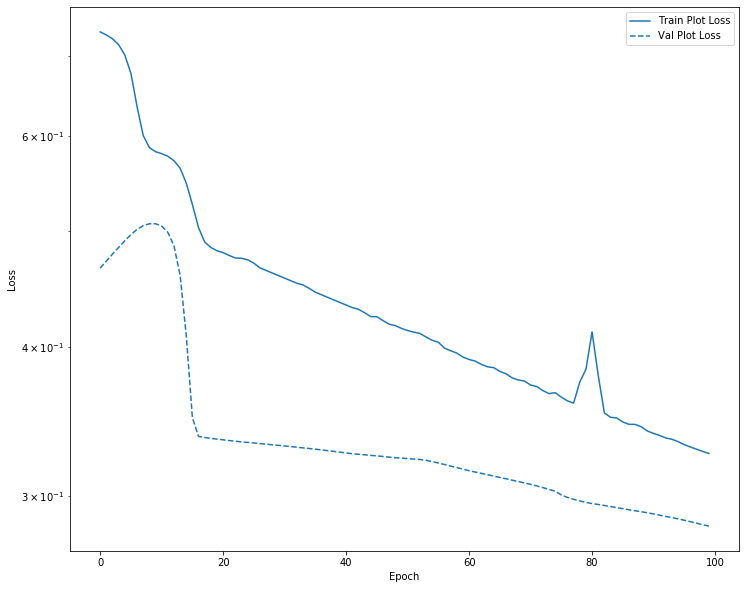

In [16]:
plot_loss(model_output, "Plot Loss", 0)

In [17]:
final_results = pd.DataFrame(cm_results, columns=('algo','TN','FP','FN','TP', 'lr', 'w1', 'w2', 'epochs', 'batch_size')) 
#sp = round((tn1 + tn2)/(tn1 + tn2 +fp2), 3)
#se = round(tp2/(tp2 + fn1 + fn2), 3)
final_results['SP'] = round(final_results['TN']/(final_results['TN'] + final_results['FP']), 3)
final_results['SE'] = round(final_results['TP']/(final_results['TP'] + final_results['FN']), 3)
final_results['Avg'] = (final_results['SP'] + final_results['SE'])/2

print(strat,OrigPct,TrainPct,TrainDownPct,TestPct)


True 0.172749 0.172549 50.0 0.173217


In [18]:
sort = final_results.sort_values(final_results.columns[5], ascending = False)
sort.to_csv('results_lstm.csv', sep=',', mode='a', encoding='utf-8', header=True)
print(sort)

           algo     TN   FP  FN  TP    lr   w1   w2  epochs  batch_size  \
0  sequential_1  42484  153  74   0  0.01  1.0  1.0     100        4096   

      SP   SE    Avg  
0  0.996  0.0  0.498  


Now for the final model

In [19]:
# Build the best model based on the parameter tuning
w1=1
w2=1
batch_size=2048
epochs=200
cm_results = []
final_model = Sequential()
final_model.add(LSTM(20, return_sequences=True, input_shape=X_train.shape[1:]))
final_model.add(Dropout(0.2))
final_model.add(LSTM(12, activation='relu', return_sequences=True))
final_model.add(Dropout(0.2))
final_model.add(LSTM(8, activation='relu', return_sequences=False)) # this is the last LSTM, so should return_sequences=False
final_model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
bias_initializer = ones/zeros 
#bias_initializer = np.log([bias_initializer])
print('bias_initializer', bias_initializer)
bias_initializer = initializers.Constant(bias_initializer)
final_model.add(Dense(units=1, activation='sigmoid', bias_initializer=bias_initializer))
optimizer = optimizers.Adam(lr=lr)
final_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) #optimizer='rmsprop', optimizer='sgd', optimizer='adam'

model_output = final_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1,
                         class_weight=np.where(y_train == 1,w1,w2).flatten(), validation_data=(val_features, val_labels) )


bias_initializer 0.0017284695005527083
Train on 678 samples, validate on 42712 samples
Epoch 1/200
678/678 [==============================] - 3s 4ms/step - loss: 0.7376 - accuracy: 0.4926 - val_loss: 0.4545 - val_accuracy: 0.9983
Epoch 2/200
678/678 [==============================] - 1s 1ms/step - loss: 0.7338 - accuracy: 0.4926 - val_loss: 0.4611 - val_accuracy: 0.9983
Epoch 3/200
678/678 [==============================] - 1s 2ms/step - loss: 0.7283 - accuracy: 0.4926 - val_loss: 0.4676 - val_accuracy: 0.9983
Epoch 4/200
678/678 [==============================] - 1s 2ms/step - loss: 0.7184 - accuracy: 0.4926 - val_loss: 0.4741 - val_accuracy: 0.9983
Epoch 5/200
678/678 [==============================] - 1s 1ms/step - loss: 0.6955 - accuracy: 0.4926 - val_loss: 0.4802 - val_accuracy: 0.9983
Epoch 6/200
678/678 [==============================] - 1s 1ms/step - loss: 0.6510 - accuracy: 0.4926 - val_loss: 0.4860 - val_accuracy: 0.9983
Epoch 7/200
678/678 [==============================] - 

In [26]:
#final_model.predict(X_val)
#final_model.predict_proba(X_val)
final_model.predict_classes(X_val)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [28]:
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 20)            3920      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 12)            1584      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 12)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 8)                 672       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [20]:
val_predict = final_model.predict_classes(X_val)

### test AUC ###

fpr, tpr, thresholds = metrics.roc_curve(y_train, train_predict, pos_label=1)
print('TRAIN | AUC Score: ' + str((metrics.auc(fpr, tpr))))
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_predict, pos_label=1)
print('TEST | AUC Score: ' + str((metrics.auc(fpr, tpr))))
fpr, tpr, thresholds = metrics.roc_curve(y_val, val_predict, pos_label=1)
print('VAL | AUC Score: ' + str((metrics.auc(fpr, tpr))))
tn, fp, fn, tp = display_metrics(final_model, X_train, X_val, y_train, y_val, val_predict)
cm_results.append([final_model.name, tn, fp, fn, tp, lr, w1, w2, epochs, batch_size])
print('lr',lr,'w1',w1,'w2',w2,'epochs',epochs,'batch_size',batch_size)
final_results = pd.DataFrame(cm_results, columns=('algo','TN','FP','FN','TP', 'lr', 'w1', 'w2', 'epochs', 'batch_size')) 
final_results['SP'] = round(final_results['TN']/(final_results['TN'] + final_results['FP']), 3)
final_results['SE'] = round(final_results['TP']/(final_results['TP'] + final_results['FN']), 3)
final_results['Avg'] = (final_results['SP'] + final_results['SE'])/2

print(final_results)


TRAIN | AUC Score: 1.0
TEST | AUC Score: 0.5043501711927209
VAL | AUC Score: 0.49924539943058316
error
error
Confusion Matrix:
false positive pct: 1.4141224948492226
tn  fp  fn  tp
42029 604 78 1
[[42029   604]
 [   78     1]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     42633
           1       0.00      0.01      0.00        79

    accuracy                           0.98     42712
   macro avg       0.50      0.50      0.50     42712
weighted avg       1.00      0.98      0.99     42712

Specificity = 0.985832571013065
Sensitivity = 0.012658227848101266
lr 0.01 w1 1 w2 1 epochs 200 batch_size 2048
           algo     TN   FP  FN  TP    lr  w1  w2  epochs  batch_size     SP  \
0  sequential_2  42029  604  78   1  0.01   1   1     200        2048  0.986   

      SE     Avg  
0  0.013  0.4995  


<pre>

So far cannot get avg of SP and SE above 50%

1) Adam is more consistent for optimization
2) Stratify doesn't make much difference, include it for consistency
3) lr needs to be less than 0.05, keep at 0.01

4) Try wts later
5) epochs
6) batch size

Details:

SGD vs Adam and Stratify vs No Stratify:

    SGD with Stratify produces inconsistent results, lots of 0's in the confusion matrix, esp TP
    Adam with stratify is much more consistent, almost always has some values in all 4 categories, and FP has less variation, even if TP count is still low (~1-3)

    SGD with Stratify:

                 algo     TN     FP   FN   TP    lr   w1   w2  epochs  batch_size  \
    0    sequential_1  79719   5566  142    6  0.01  4.0  1.0      10           8   
    13  sequential_14  85202     83  148    0  0.01  4.0  1.0      10           8   
    23  sequential_24  85160    125  148    0  0.01  4.0  1.0      10           8   
    22  sequential_23  40018  45267   69   79  0.01  4.0  1.0      10           8   
    21  sequential_22  85279      6  148    0  0.01  4.0  1.0      10           8   
    20  sequential_21  84649    636  148    0  0.01  4.0  1.0      10           8   
    19  sequential_20  85221     64  148    0  0.01  4.0  1.0      10           8   
    18  sequential_19  85252     33  148    0  0.01  4.0  1.0      10           8 


    SGD without Stratify:

                 algo     TN     FP   FN   TP    lr   w1   w2  epochs  batch_size  \
    0    sequential_1  85216     77  140    0  0.01  4.0  1.0      10           8   
    13  sequential_14  85035    258  138    2  0.01  4.0  1.0      10           8   
    23  sequential_24  85255     38  139    1  0.01  4.0  1.0      10           8   
    22  sequential_23  83812   1481  138    2  0.01  4.0  1.0      10           8   
    21  sequential_22  84769    524  140    0  0.01  4.0  1.0      10           8   
    20  sequential_21  76723   8570  129   11  0.01  4.0  1.0      10           8   
    19  sequential_20  85146    147  139    1  0.01  4.0  1.0      10           8

    ADAM with Stratify:

                 algo     TN    FP   FN  TP    lr   w1   w2  epochs  batch_size  \
    0    sequential_1  84840   445  147   1  0.01  4.0  1.0      10           8   
    13  sequential_14  84984   301  148   0  0.01  4.0  1.0      10           8   
    23  sequential_24  84613   672  148   0  0.01  4.0  1.0      10           8   
    22  sequential_23  84447   838  147   1  0.01  4.0  1.0      10           8   
    21  sequential_22  84386   899  148   0  0.01  4.0  1.0      10           8   
    20  sequential_21  85037   248  148   0  0.01  4.0  1.0      10           8   
    19  sequential_20  84207  1078  145   3  0.01  4.0  1.0      10           8   
    18  sequential_19  85001   284  148   0  0.01  4.0  1.0      10           8   
    17  sequential_18  84990   295  148   0  0.01  4.0  1.0      10           8   
    16  sequential_17  84863   422  148   0  0.01  4.0  1.0      10           8   
    15  sequential_16  84585   700  147   1  0.01  4.0  1.0      10           8   
    14  sequential_15  84728   557  148   0  0.01  4.0  1.0      10           8   
    12  sequential_13  84396   889  146   2  0.01  4.0  1.0      10           8   
    ADAM without Stratify:

                 algo     TN    FP   FN  TP    lr   w1   w2  epochs  batch_size  \
    0    sequential_1  84218  1055  159   1  0.01  4.0  1.0      10           8   
    13  sequential_14  85036   237  160   0  0.01  4.0  1.0      10           8   
    23  sequential_24  84721   552  159   1  0.01  4.0  1.0      10           8   
    22  sequential_23  84609   664  160   0  0.01  4.0  1.0      10           8   
    21  sequential_22  84730   543  160   0  0.01  4.0  1.0      10           8   
    20  sequential_21  85046   227  160   0  0.01  4.0  1.0      10           8   
    19  sequential_20  84771   502  158   2  0.01  4.0  1.0      10           8   
    18  sequential_19  84612   661  160   0  0.01  4.0  1.0      10           8   
    17  sequential_18  82808  2465  154   6  0.01  4.0  1.0      10           8   
    16  sequential_17  84382   891  159   1  0.01  4.0  1.0      10           8   
    15  sequential_16  84715   558  160   0  0.01  4.0  1.0      10           8   
    14  sequential_15  84879   394  160   0  0.01  4.0  1.0      10           8   
    12  sequential_13  85240    33  160   0  0.01  4.0  1.0      10           8   
    1    sequential_2  84906   367  160   0  0.01  4.0  1.0      10           8   

lr values (ADAM and Stratify): use value of 0.025

need value less than 0.05 to show consistency in results

             algo     TN     FP   FN   TP        lr   w1   w2  epochs  \
24  sequential_25  85285      0  148    0  0.100000  4.0  1.0      10   
23  sequential_24  85285      0  148    0  0.100000  4.0  1.0      10   
22  sequential_23  85285      0  148    0  0.100000  4.0  1.0      10   
21  sequential_22      0  85285    0  148  0.100000  4.0  1.0      10   
20  sequential_21      1  85284    0  148  0.100000  4.0  1.0      10   
19  sequential_20  84877    408  144    4  0.075025  4.0  1.0      10   
18  sequential_19  84508    777  144    4  0.075025  4.0  1.0      10   
17  sequential_18      0  85285    0  148  0.075025  4.0  1.0      10   
16  sequential_17  81305   3980  141    7  0.075025  4.0  1.0      10   
15  sequential_16  84733    552  145    3  0.075025  4.0  1.0      10  
**** cutoff here
13  sequential_14  83804   1481  143    5  0.050050  4.0  1.0      10   
14  sequential_15  83316   1969  143    5  0.050050  4.0  1.0      10   
12  sequential_13  85011    274  147    1  0.050050  4.0  1.0      10   
11  sequential_12  84644    641  144    4  0.050050  4.0  1.0      10   
10  sequential_11  85131    154  147    1  0.050050  4.0  1.0      10   
9   sequential_10  84520    765  145    3  0.025075  4.0  1.0      10   
8    sequential_9  84118   1167  142    6  0.025075  4.0  1.0      10   
7    sequential_8  84874    411  147    1  0.025075  4.0  1.0      10   
6    sequential_7  84557    728  144    4  0.025075  4.0  1.0      10   
5    sequential_6  84555    730  144    4  0.025075  4.0  1.0      10   
1    sequential_2  85038    247  147    1  0.000100  4.0  1.0      10   
4    sequential_5  85123    162  146    2  0.000100  4.0  1.0      10   
3    sequential_4  85026    259  147    1  0.000100  4.0  1.0      10   
2    sequential_3  84763    522  146    2  0.000100  4.0  1.0      10   
0    sequential_1  84537    748  146    2  0.000100  4.0  1.0      10


             algo     TN    FP   FN  TP        lr   w1   w2  epochs  \
24  sequential_25  84318   967  146   2  0.050000  4.0  1.0      10   
23  sequential_24  85045   240  147   1  0.050000  4.0  1.0      10   
22  sequential_23  84672   613  146   2  0.050000  4.0  1.0      10   
21  sequential_22  82670  2615  142   6  0.050000  4.0  1.0      10   
20  sequential_21  83087  2198  146   2  0.050000  4.0  1.0      10   
19  sequential_20  84231  1054  148   0  0.037525  4.0  1.0      10   
18  sequential_19  85006   279  148   0  0.037525  4.0  1.0      10   
17  sequential_18  84610   675  148   0  0.037525  4.0  1.0      10   
16  sequential_17  84759   526  148   0  0.037525  4.0  1.0      10   
15  sequential_16  84522   763  148   0  0.037525  4.0  1.0      10   
13  sequential_14  83834  1451  146   2  0.025050  4.0  1.0      10   
14  sequential_15  83814  1471  146   2  0.025050  4.0  1.0      10   
12  sequential_13  84764   521  148   0  0.025050  4.0  1.0      10   
11  sequential_12  84809   476  147   1  0.025050  4.0  1.0      10   
10  sequential_11  84723   562  147   1  0.025050  4.0  1.0      10   
9   sequential_10  84879   406  148   0  0.012575  4.0  1.0      10   
8    sequential_9  83464  1821  147   1  0.012575  4.0  1.0      10   
7    sequential_8  84803   482  148   0  0.012575  4.0  1.0      10   
6    sequential_7  82689  2596  144   4  0.012575  4.0  1.0      10   
5    sequential_6  83254  2031  147   1  0.012575  4.0  1.0      10   
1    sequential_2  84693   592  148   0  0.000100  4.0  1.0      10   
4    sequential_5  85028   257  148   0  0.000100  4.0  1.0      10   
3    sequential_4  84807   478  148   0  0.000100  4.0  1.0      10   
2    sequential_3  84371   914  148   0  0.000100  4.0  1.0      10   
0    sequential_1  84495   790  148   0  0.000100  4.0  1.0      10  

In [21]:
print('finish')

finish
